# hit-song-classifier

## Random Forest Classification

The first thing we'll do is define our imports and declare any constants.


In [1]:
# Define our imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


# Define our constants
TARGET_DATA = "../../data/join_datasets1.csv"
RANDOM_SEED = 0
TARGET_FEATURES = [
    "danceability",
    "duration",
    "energy",
    "key",
    "loudness",
    "song_hotttnesss",
    "tempo",
    "time_signature",
]


Next, we shall split our data in a 60-20-20 train_test_val split. Then we shall build our set of inputs X. We don't want to include the features `[song, artist, year]` since they are keys. We also should define our label `class` since that is our classification feature.


In [2]:
def load_data(filename: str) -> pd.DataFrame:
    """Load data from file

    Args:
        filename (str): filename

    Returns:
        DataFrame: pyspark dataframe
    """
    return pd.read_csv(filename)


def split_data(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Splits data to train, val, test splits

    Args:
        df (DataFrame): full dataframe

    Returns:
        DataFrame: _description_
    """
    train, test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
    train, val = train_test_split(train, test_size=0.25, random_state=RANDOM_SEED)
    return train, val, test


df = load_data(TARGET_DATA)
train_df, val_df, test_df = split_data(df)
print(f"Train: {train_df.shape}\nTest: {test_df.shape}\nVal: {val_df.shape}")


Train: (3388, 12)
Test: (1130, 12)
Val: (1130, 12)


## Hyperparameter search: training multiple estimators

Here we will train multiple estimators with different hyperparameter settings. For SVCs, the hyperparameters we've chosen include regularization parameter `C` and `max_iter`.


In [3]:
def train_estimators(
    X, y, estimator_type: any, param_name: str, param_vals: list[int], **kwargs
) -> list:
    """Trains a list of estimators"""
    estimators = []
    for val in param_vals:
        estimator = estimator_type(**{param_name: val}, **kwargs)
        estimator.fit(X, y)
        estimators.append(estimator)
        print(f"Training {estimator}")
    return estimators


In [4]:
c_svc = [0.01, 0.1, 1, 10, 100, 1000]
svm_multi = train_estimators(
    train_df[TARGET_FEATURES],
    train_df["class"],
    SVC,
    "C",
    c_svc,
    random_state=RANDOM_SEED,
)


Training SVC(C=0.01, random_state=0)
Training SVC(C=0.1, random_state=0)
Training SVC(C=1, random_state=0)
Training SVC(C=10, random_state=0)
Training SVC(C=100, random_state=0)
Training SVC(C=1000, random_state=0)


We want to plot estimator scores to pick the estimator with the best score.


In [5]:
def score_estimators(X, y, estimators: list) -> list:
    """Scores a list of estimators"""
    return [estimator.score(X, y) for estimator in estimators]


print(f"train: {score_estimators(train_df[TARGET_FEATURES], train_df['class'], svm_multi)}")
print(f"val: {score_estimators(val_df[TARGET_FEATURES], val_df['class'], svm_multi)}")
print(f"test: {score_estimators(test_df[TARGET_FEATURES], test_df['class'], svm_multi)}")


train: [0.9843565525383707, 0.9843565525383707, 0.9843565525383707, 0.9843565525383707, 0.9843565525383707, 0.9843565525383707]
val: [0.9849557522123894, 0.9849557522123894, 0.9849557522123894, 0.9849557522123894, 0.9849557522123894, 0.9849557522123894]
test: [0.9849557522123894, 0.9849557522123894, 0.9849557522123894, 0.9849557522123894, 0.9849557522123894, 0.9849557522123894]


In [6]:
def plot_estimator_scores(estimators: list, param_name: str, param_vals: list[int]):
    """Plots the scores of a list of estimators"""

    train_score = score_estimators(train_df[TARGET_FEATURES], train_df["class"], estimators)
    val_score = score_estimators(val_df[TARGET_FEATURES], val_df["class"], estimators)
    test_score = score_estimators(test_df[TARGET_FEATURES], test_df["class"], estimators)

    # Get the best validation score and the index of the best estimator
    best_val_score = max(val_score)
    best_val_idx = val_score.index(best_val_score)

    # Plot metrics
    plt.figure()
    plt.plot(np.arange(len(train_score)), train_score, "go-", label="train")
    plt.plot(np.arange(len(val_score)), val_score, "ro-", label="val")
    plt.plot(np.arange(len(test_score)), test_score, "k:", label="test")
    # Place an X at the best validation score
    plt.scatter(best_val_idx, best_val_score, marker="x", color="r", s=200)

    # Additional formatting
    plt.ylim(0, 1.05)
    plt.xticks(ticks=np.arange(len(train_score)), labels=param_vals)
    plt.ylabel("score")
    plt.xlabel(param_name)
    plt.title(f"{estimators[0].__class__.__name__} score vs. {param_name}")
    
    # Output scores at max_depth of the best_validation_score
    plt.text(4.7, 0.3, f"train = {train_score[best_val_idx]:.3f}", c='g', ha='right')
    plt.text(4.7, 0.2, f"validate = {best_val_score:.3f}", c='r', ha='right')
    plt.text(4.7, 0.1, f"test = {test_score[best_val_idx]:.3f}", c='k', ha='right')
    plt.legend()

CPU times: user 1.12 s, sys: 10.7 ms, total: 1.13 s
Wall time: 1.14 s


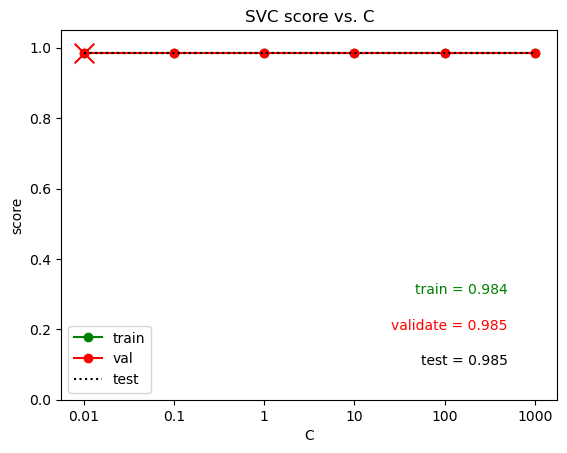

In [7]:
%%time
plot_estimator_scores(svm_multi, "C", c_svc)

In [8]:
max_iter = [1, 5, 10, 20, 50, 100]
svm_iter = train_estimators(train_df[TARGET_FEATURES], train_df["class"], SVC, "max_iter", max_iter, random_state=RANDOM_SEED)

/usr/local/Caskroom/miniconda/base/envs/soen/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/soen/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/soen/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/soen/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local

Training SVC(max_iter=1, random_state=0)
Training SVC(max_iter=5, random_state=0)
Training SVC(max_iter=10, random_state=0)
Training SVC(max_iter=20, random_state=0)
Training SVC(max_iter=50, random_state=0)
Training SVC(max_iter=100, random_state=0)


CPU times: user 581 ms, sys: 4.62 ms, total: 585 ms
Wall time: 586 ms


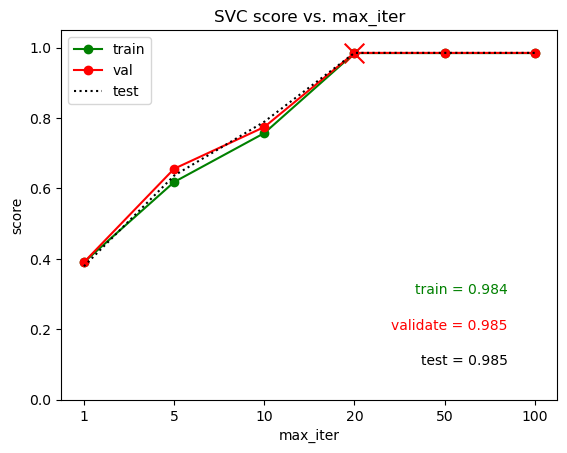

In [9]:
%%time
plot_estimator_scores(svm_iter, "max_iter", max_iter)

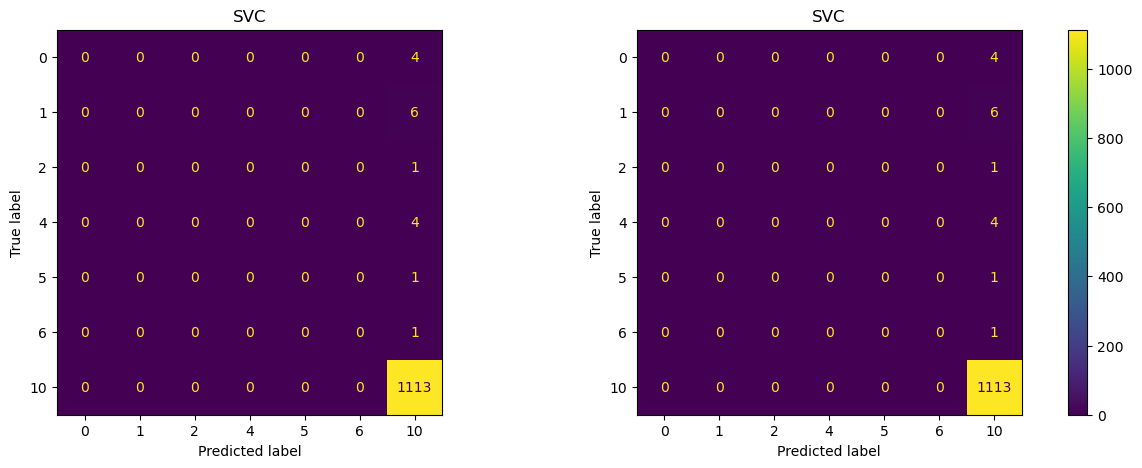

In [10]:
model_list = [svm_multi, svm_iter]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for i, model in enumerate(model_list):
    val_score = score_estimators(val_df[TARGET_FEATURES], val_df["class"], model)
    best_val_score = max(val_score)
    best_val_idx = val_score.index(best_val_score)

    # Generate confusion matrix
    con_mtrx = sklearn.metrics.ConfusionMatrixDisplay.from_estimator(
        model[best_val_idx],
        test_df[TARGET_FEATURES],
        test_df["class"],
        display_labels=set(test_df["class"]),
        ax=axes[i % 2],
        colorbar=False,
    )

    con_mtrx.ax_.set_title(model[best_val_idx].__class__.__name__)

fig.colorbar(con_mtrx.im_, ax=axes, fraction=0.046, pad=0.04);
